<a id='Top'></a>

# Prepare imaging data <a class='tocSkip'></a>

Use an offline patching scheme to sample patches from whole-slide images (WSIs) ahead of model training/testing. Generate a file per patient (as for other data modalities), but containing the file names of image patches sampled from that patient's WSI `.svs` files, rather than the data. These are used by the PyTorch dataset to load patient image patches.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark
import os
from io import StringIO
import json
from collections import Counter

import numpy as np
from PIL import Image, UnidentifiedImageError
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import openslide as slide

In [2]:
DATA_LOCATION = '/mnt/data/Processed_Data/WSI/'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Subset-manifest-file" data-toc-modified-id="Subset-manifest-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Subset manifest file</a></span></li><li><span><a href="#Map-files-to-patients" data-toc-modified-id="Map-files-to-patients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map files to patients</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Slides-with-max-20x-magnification" data-toc-modified-id="Slides-with-max-20x-magnification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Slides with max 20x magnification</a></span><ul class="toc-item"><li><span><a href="#Collect-slide-magnifications" data-toc-modified-id="Collect-slide-magnifications-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collect slide magnifications</a></span></li><li><span><a href="#Save-slide-magnifications-to-file" data-toc-modified-id="Save-slide-magnifications-to-file-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Save slide magnifications to file</a></span></li><li><span><a href="#Check-unread-slides" data-toc-modified-id="Check-unread-slides-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Check unread slides</a></span></li><li><span><a href="#Drop-unusable-slides" data-toc-modified-id="Drop-unusable-slides-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Drop unusable slides</a></span><ul class="toc-item"><li><span><a href="#Drop-slides-slides-missing-magnification-or-with-20x-magnification" data-toc-modified-id="Drop-slides-slides-missing-magnification-or-with-20x-magnification-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Drop slides slides missing magnification or with 20x magnification</a></span></li><li><span><a href="#Drop-patients-with-no-remaining-slides" data-toc-modified-id="Drop-patients-with-no-remaining-slides-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Drop patients with no remaining slides</a></span></li></ul></li></ul></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate patient files</a></span></li><li><span><a href="#Offline-patching" data-toc-modified-id="Offline-patching-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Offline patching</a></span><ul class="toc-item"><li><span><a href="#Count-generated-patches-per-slide" data-toc-modified-id="Count-generated-patches-per-slide-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Count generated patches per slide</a></span></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Generate patient files</a></span></li><li><span><a href="#Reorganize-directory" data-toc-modified-id="Reorganize-directory-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Reorganize directory</a></span></li><li><span><a href="#Delete-bad-patches" data-toc-modified-id="Delete-bad-patches-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Delete bad patches</a></span><ul class="toc-item"><li><span><a href="#Find-outliers" data-toc-modified-id="Find-outliers-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Find outliers</a></span></li><li><span><a href="#Visualize-outlier-examples" data-toc-modified-id="Visualize-outlier-examples-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Visualize outlier examples</a></span></li><li><span><a href="#Delete-outlier-patch-files" data-toc-modified-id="Delete-outlier-patch-files-5.4.3"><span class="toc-item-num">5.4.3&nbsp;&nbsp;</span>Delete outlier patch files</a></span></li><li><span><a href="#Generate-patient-files" data-toc-modified-id="Generate-patient-files-5.4.4"><span class="toc-item-num">5.4.4&nbsp;&nbsp;</span>Generate patient files</a></span></li></ul></li></ul></li><li><span><a href="#Compute-patch-mean-and-std" data-toc-modified-id="Compute-patch-mean-and-std-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute patch mean and std</a></span></li></ul></div>

In [40]:
downloaded_samples = '/mnt/data/RawData/WSI'

In [41]:
len(downloaded_samples)

21

In [50]:
complete_files = []
index = 0
for folder in os.listdir(downloaded_samples):
    folder_path = os.path.join(downloaded_samples, folder)
    if not os.path.isdir(folder_path):
        continue

    for f in os.listdir(folder_path):
        if 'partial' in f.lower() or f.lower().endswith('.partial'):
            continue
        elif f.lower().endswith('.svs'):
            complete_files.append(folder)
    index+=1
print(len(complete_files))

3102


In [51]:
manifest_file = os.path.join('/app/data/manifests/',
                             'gdc_manifest.2025-06-01-wsi.txt')
manifest = pd.read_csv(manifest_file, sep='\t', index_col='id')

In [52]:
manifest.shape

(3102, 4)

In [53]:
manifest[~manifest.index.isin(complete_files)].shape

(0, 4)

In [54]:
sub_manifest = manifest[~manifest.index.isin(complete_files)]
sub_manifest.shape

(0, 4)

In [55]:
sub_manifest.reset_index(level=0, inplace=True)

In [56]:
sub_manifest.head(3)

,id,filename,md5,size,state


In [57]:
sub_manifest_file = os.path.join('/app/data/manifests/',
                             'gdc_manifest.2025-06-01-wsi_subset.txt')
sub_manifest.to_csv(sub_manifest_file, sep='\t', index=False)

In [58]:
# check for undownloaded files and create a new subset manifest
manifest_path = '/app/data/manifests/gdc_manifest.2025-06-01-wsi.txt'
download_dir = '/mnt/data/RawData/WSI/'
subset_manifest_path = '/app/data/manifests/gdc_manifest.2025-06-01-wsi_subset.txt'

# Load manifest
manifest = pd.read_csv(manifest_path, sep='\t')

# Recursively get all filenames in the download directory
downloaded_files = []
for root, dirs, files in os.walk(download_dir):
    for file in files:
        downloaded_files.append(file)

# Filter: Keep only rows where filename is NOT in downloaded files
not_downloaded = manifest[~manifest['filename'].isin(downloaded_files)]

# Save to new manifest
not_downloaded.to_csv(subset_manifest_path, sep='\t', index=False)

print(f"Subset manifest saved with {len(not_downloaded)} files.")

Subset manifest saved with 0 files.


# Map files to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping between file names and patient IDs. Collect results as Pandas `DataFrame`.

In [60]:
def request_file_info(data_type):
    fields = [
        "file_name",
        "cases.submitter_id",
        "cases.samples.sample_type",
        "cases.project.project_id",
        "cases.project.primary_site",
        ]

    fields = ",".join(fields)

    files_endpt = "https://api.gdc.cancer.gov/files"

    filters = {
        "op": "and",
        "content":[
            {
            "op": "in",
            "content":{
                "field": "files.experimental_strategy",
                "value": [data_type]
                }
            },
                        {
            "op": "in",
            "content":{
                "field": "files.access",
                "value": ['open']
                }
            }
        ]
    }

    params = {
        "filters": filters,
        "fields": fields,
        "format": "TSV",
        "size": "200000"
        }

    response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)

    return pd.read_csv(StringIO(response.content.decode("utf-8")), sep="\t")

In [61]:
wsi_files = request_file_info(data_type='Diagnostic Slide')
wsi_files.shape

(11766, 7)

In [62]:
wsi_files.head()

,cases.0.project.primary_site,cases.0.project.project_id,cases.0.samples.0.sample_type,cases.0.samples.1.sample_type,cases.0.submitter_id,file_name,id
0,Breast,TCGA-BRCA,Primary Tumor,NaN,TCGA-BH-A0C1,TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFE...,aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18
1,Breast,TCGA-BRCA,Primary Tumor,NaN,TCGA-EW-A1P1,TCGA-EW-A1P1-01Z-00-DX1.4B670029-4B3B-4D76-8EA...,a779fff9-b54a-4c18-936f-43f75119b9ad
2,Breast,TCGA-BRCA,Primary Tumor,NaN,TCGA-E9-A5FL,TCGA-E9-A5FL-01Z-00-DX1.FB810D6A-303E-45DF-BEF...,e5806a73-54c4-43d1-a44b-db5f43c8e832
3,Breast,TCGA-BRCA,Primary Tumor,NaN,TCGA-AC-A23G,TCGA-AC-A23G-01Z-00-DX1.2F0326F7-6B77-4B3F-B4F...,2449ff02-6925-4f25-9074-7c5fbeab0bd2
4,Breast,TCGA-BRCA,Primary Tumor,NaN,TCGA-AO-A1KO,TCGA-AO-A1KO-01Z-00-DX1.EEB5E0A0-92B2-42CD-9F7...,03a7acd9-178a-4165-9588-fa63e46f3387


In [63]:
wsi_files = wsi_files[wsi_files['cases.0.project.project_id'].str.startswith('TCGA-BRCA')]
wsi_files = wsi_files[wsi_files['file_name'].str.endswith('.svs')]
wsi_files = wsi_files[wsi_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
wsi_files.shape

(1132, 7)

In [64]:
print('All rows:       ', wsi_files.shape[0])
print('Unique patients:', wsi_files['cases.0.submitter_id'].unique().shape[0])

All rows:        1132
Unique patients: 1061


In [65]:
def make_patient_file_map(df, base_dir):
    d = {}
    
    for _, row in df.iterrows():
        patient = row['cases.0.submitter_id']
        if patient in d:
            if not isinstance(d[patient], tuple):
                d[patient] = (
                    d[patient],
                    os.path.join(base_dir, row.id, row.file_name))
            else:
                d[patient] += os.path.join(base_dir, row.id, row.file_name),
        else:
            d[patient] = os.path.join(base_dir, row.id, row.file_name)

    return d

In [66]:
file_map = make_patient_file_map(wsi_files, base_dir='')
len(file_map)

1061

In [67]:
file_map[list(file_map.keys())[0]]

'aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18/TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFEF-7E96E994236A.svs'

## Drop unused patients

Keep only patients present in label data.

In [68]:
labels = pd.read_csv('labels.tsv', sep='\t')
len(labels['submitter_id'])

1094

In [69]:
labels.head()

,submitter_id,time,event,group
0,TCGA-Z7-A8R6,8.920548,0,train
1,TCGA-C8-A1HE,1.027397,0,train
2,TCGA-A8-A07B,3.583562,0,train
3,TCGA-AC-A2FM,2.169863,1,train
4,TCGA-B6-A1KF,8.460274,0,train


In [70]:
file_map = {k: file_map[k] for k in file_map if k in list(labels['submitter_id'])}

In [71]:
len(file_map)

1058

In [72]:
slide_counts = {}

for patient in file_map:
    slides = file_map[patient]
    if isinstance(slides, tuple):
        slide_counts[patient] = len(slides)

print(len(slide_counts), 'patients with more than one slide')
print(f'(with {round(np.mean(list(slide_counts.values())), 2)} slides per patient)')

64 patients with more than one slide
(with 2.08 slides per patient)


# Slides with max 20x magnification

There are slides with a maximum magnification of 20x instead of 40x. Drop these slides from the data.

> __Note:__ De to the large size of the data, I have sp;it and stored it across four different locations.

## Collect slide magnifications

In [73]:
location_paths = { 'wsi': '/mnt/data/RawData/WSI' }

In [74]:
location_files = { 'wsi': os.listdir(location_paths['wsi']) }

In [75]:
location_files['wsi'][:5]

['0018cc22-498a-45b8-bfd4-b0fe0c3a2f0a',
 '006984cf-35fc-4bc3-a0db-7f5b68de4a6e',
 '0070d4e9-f838-4ee9-a48b-c894b3b86440',
 '009f90d0-53c9-48a9-a362-72328cccd66e',
 '00ab866f-a0a3-44c0-ad14-c9dc833239a7']

In [76]:
[len(l) for _, l in location_files.items()]

[3102]

In [77]:
def get_slide_mag(slide_file):
    try:
        wsi = slide.OpenSlide(filename=slide_file)
        d = dict(wsi.properties)
    except:
        return slide_file
    if 'aperio.AppMag' in d.keys():
        mag = d['aperio.AppMag']
        return mag
    else:
        return slide_file

def lookup_full_path(wsi_file, slide_paths, locations):
    # Get all folder names from the WSI path (excluding the .svs filename)
    folders = os.path.dirname(wsi_file).split('/')

    for location, leaf_dirs in slide_paths.items():
        if any(folder in leaf_dirs for folder in folders):
            return os.path.join(locations[location], wsi_file)

    return None

In [78]:
%%time

slide_mags = {}

print('Collecting slide magnifications:')
n = len(file_map)
        
for i, patient in enumerate(file_map):
#     if i > 100:
#         break
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    if isinstance(file_map[patient], tuple):
        slide_mags[patient] = tuple()
        for f in file_map[patient]:
            f = lookup_full_path(f, location_files, location_paths)
            if f is not None:
                slide_mags[patient] += get_slide_mag(f),
    else:
        f = lookup_full_path(file_map[patient], location_files, location_paths)
        if f is not None:
            slide_mags[patient] = get_slide_mag(
                lookup_full_path(f, location_files, location_paths))
print()

1058/1058
CPU times: user 9.77 s, sys: 12.9 s, total: 22.7 s
Wall time: 5min 39s


In [79]:
len(slide_mags)

1057

## Save slide magnifications to file

In [80]:
with open('/app/data/wsi_magnifications.json', 'w') as f:
    json.dump(slide_mags, f)

## Check unread slides

Function `get_slide_mag()` returns the slide file name when the magnification is not found (no `'aperio.AppMag'` found in `Slide` attributes).

Start by checking unreadable slides and manually download the cases where the problem is partial original downloads.

In [81]:
slide_mags = json.load(open('/app/data/wsi_magnifications.json'))

In [82]:
patients_with_failed_slides = []

for patient in slide_mags:
    mags = slide_mags[patient]
    if not isinstance(mags, list):
        mags = [mags]
    for x in mags:
        if x.startswith('20') or x.startswith('40'):
            next
        else:
            patients_with_failed_slides += [patient]

In [83]:
len(patients_with_failed_slides)

7

In [84]:
%%time

fail_opening = []

for patient in patients_with_failed_slides:
    files = slide_mags[patient]
    if not isinstance(files, list):
        files = [files]
    for file in files:
        try:
            slide.OpenSlide(filename=file)
        except:
            fail_opening += [patient]

CPU times: user 30.1 ms, sys: 90.3 ms, total: 120 ms
Wall time: 1.44 s


In [85]:
len(set(fail_opening))

0

In [86]:
set(fail_opening)

set()

In [87]:
slide_mags['TCGA-AR-A0TQ']

'40'

In [88]:
wsi = slide.OpenSlide(filename='/mnt/data/RawData/WSI/00cf804f-0136-43c0-88c3-c36690d87875/TCGA-AR-A0TQ-01A-01-TSA.aa243f75-79d1-42b5-958a-6beaf7ae7a86.svs')
d = dict(wsi.properties)
d

# d['aperio.AppMag']

{'aperio.AppMag': '40',
 'aperio.DSR ID': 'resc3-dsr2',
 'aperio.Date': '09/07/10',
 'aperio.DisplayColor': '0',
 'aperio.Exposure Scale': '0.000001',
 'aperio.Exposure Time': '109',
 'aperio.Filename': 'TCGA-AR-A0TQ-01A-01-TSA',
 'aperio.Focus Offset': '-0.000500',
 'aperio.ICC Profile': 'ScanScope v1',
 'aperio.ImageID': '30078',
 'aperio.Left': '26.281858',
 'aperio.LineAreaXOffset': '-0.014041',
 'aperio.LineAreaYOffset': '0.000544',
 'aperio.LineCameraSkew': '0.000833',
 'aperio.MPP': '0.2485',
 'aperio.OriginalHeight': '35567',
 'aperio.OriginalWidth': '115000',
 'aperio.Parmset': 'CHTN FocusRad18 on RESBPCLACIE01',
 'aperio.ScanScope ID': 'SS1436CNTLR',
 'aperio.StripeWidth': '1000',
 'aperio.Time': '09:11:35',
 'aperio.Title': 'TCGA-AR-A0TQ-01A-01-TSA',
 'aperio.Top': '16.811081',
 'aperio.User': '00f5c00f-24a9-41e6-a23f-7085209a268e',
 'openslide.associated.thumbnail.height': '329',
 'openslide.associated.thumbnail.width': '1024',
 'openslide.comment': 'Aperio Image Library v1

## Drop unusable slides

Start by checking magnifications for all flagged slides, in case the repaired files contain magnification values. Then drop both slides missing magnification info or with 20x maximum magnification and any patients with no remaining slides.

In [89]:
slide_mags = json.load(open('wsi_magnifications.json'))

In [90]:
# Any patients with slide paths for which magnification is available?
patients_with_failed_slides = []

for patient in slide_mags:
    mags = slide_mags[patient]
    if not isinstance(mags, list):
        mags = [mags]
    for x in mags:
        if x.startswith('20') or x.startswith('40'):
            next
        else:
            patients_with_failed_slides += [patient]

In [91]:
len(slide_mags) == len(file_map)

False

In [92]:
def any_slide_mag(slide_file):
    try:
        wsi = slide.OpenSlide(filename=slide_file)
        d = dict(wsi.properties)
        if 'aperio.AppMag' in d.keys():
            print(slide_file, d['aperio.AppMag'])
    except:
        print('Could not open file:', slide_file)

for patient in patients_with_failed_slides:
    mags = slide_mags[patient]
    if not isinstance(mags, list):
        mags = [mags]
    for mag in mags:
        if mag.startswith('20') or mag.startswith('40'):
            next
        else:
            any_slide_mag(mag)

### Drop slides slides missing magnification or with 20x magnification

In [93]:
# Convert all values to list
for patient in slide_mags:
    if not isinstance(slide_mags[patient], list):
        slide_mags[patient] = [slide_mags[patient]]

# Drop 20x values
for patient in slide_mags:
    slide_mags[patient] = [x for x in slide_mags[patient]
                           if not x.startswith('20')]
    
# Drop file values
for patient in slide_mags:
    slide_mags[patient] = [x for x in slide_mags[patient]
                           if x.startswith('40')]

### Drop patients with no remaining slides

In [94]:
len(slide_mags)

1057

In [95]:
patients_with_no_slides = []

for patient in slide_mags:
    if not slide_mags[patient]:
        patients_with_no_slides += [patient]

In [96]:
len(patients_with_no_slides)

144

In [97]:
slide_mags = {patient: v for patient, v in slide_mags.items()
              if patient not in patients_with_no_slides}

In [98]:
len(slide_mags)

913

In [99]:
len(file_map)

1058

In [100]:
file_map = {patient: v for patient, v in file_map.items()
            if patient in slide_mags}

In [101]:
len(file_map)

913

# Generate patient files

In [102]:
eg_file = list(file_map.values())[0]

lookup_full_path(eg_file, location_files, location_paths)

'/mnt/data/RawData/WSI/aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18/TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFEF-7E96E994236A.svs'

In [103]:
location_paths

{'wsi': '/mnt/data/RawData/WSI'}

In [105]:
def get_target_dir(patient, base_dirs, id_groups):
    if patient in id_groups['train']:
        target_dir = os.path.join(base_dir, 'train')
    elif patient in id_groups['val']:
        target_dir = os.path.join(base_dir, 'val')
    elif patient in id_groups['test']:
        target_dir = os.path.join(base_dir, 'test')
    else:
        raise ValueError(f'Patient id {patient} not found in "id_groups"!')
    
    return target_dir

In [106]:
print('Write patient files:')
n = len(file_map)

base_dir = '/mnt/data/Processed_Data/WSI/'
id_groups = {
    split: labels.loc[labels['group'] == split, 'submitter_id'].tolist()
    for split in labels['group'].unique()
}

for i, patient in enumerate(file_map):
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    patient_files = file_map[patient]
    if not isinstance(patient_files, (tuple, list)):
        file_paths = [patient_files]

    target_dir = get_target_dir(patient, base_dir, id_groups)
    os.makedirs(target_dir, exist_ok=True)
    target_file = os.path.join(target_dir, str(patient) + '.txt')

    file_paths = [lookup_full_path(file_path, location_files, location_paths)
                  for file_path in file_paths if file_path is not None]
    
    # Remove None (file not yet downloaded...)
    file_paths = [f for f in file_paths if f is not None]

    with open(target_file, 'w') as f:
        f.write('\n'.join(file_paths))

Write patient files:
913/913

# Offline patching

Run dedicated script (found in `src/scripts` directory) with a selected input directory at a time.

Slide directories:
* `/home/luis/net/Isilon/data.isilon/ag-rohr/bq_lsilva/WSI/`
* `/home/luis/net/gpu_rig/bq_lsilva/WSI/`
* `/mnt/dataB/WSI/`
* `/mnt/dataB/nas_copy/data/Projects/imaging_genomics/TCGA_BRCA/diagnostic_slide/`

Generate a good number of patches per WSI. For example, 50 patches per slide will yield the following total numbers of patches:
* 302'450 for Isilon
* 134'600 for GPU rig
* 94'600 for `dataB`
* 56'650 for BRCA

Example command:

```bash
$ conda activate ig
$ python ./wsi_patcher.py \
   -i /home/luis/net/gpu_rig/bq_lsilva/WSI/ \
   -l ../../data/labels.tsv \
   -o /mnt/dataA/TCGA/processed/WSI/tissue_patches/ \
   -n 50
```

## Count generated patches per slide

Sanity check to make sure there is a balanced number of patches per each slide.

In [123]:
base_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

In [124]:
from collections import Counter

patches_named_as_slides = ['-'.join(os.path.basename(patch).split('-')[:3])
                           for patch in os.listdir(base_dir)]
    
c = Counter(patches_named_as_slides)

In [125]:
len([x for x in c if c[x] > 0])

1093

In [110]:
def how_many_patches_per_patient(patch_dir):
    patches_named_as_patients = ['-'.join(patch.split('-')[:3])
                                 for patch in os.listdir(patch_dir)]
    
    c = Counter(patches_named_as_patients)

    print(f'# patches: {len(patches_named_as_patients)}')
    print(f'# Represented patients: {len(c)}')
    unique_counts = set(c.values())
    print(f'Unique #s patches per patient: {unique_counts}')

In [111]:
location_paths = base_dir

In [114]:
%%time

location_files = os.listdir(location_paths)

CPU times: user 23.2 ms, sys: 27 ms, total: 50.2 ms
Wall time: 418 ms


In [116]:
n_files = len(location_files)
n_files

116798

In [118]:
print('Total # of WSI files:', n_files)

Total # of WSI files: 116798


In [119]:
base_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

how_many_patches_per_patient(patch_dir=base_dir)

# patches: 116982
# Represented patients: 1093
Unique #s patches per patient: {1, 130, 2, 100, 200, 300, 50, 149, 150, 249, 250, 350}


## Generate patient files

In [126]:
def lookup_full_path(wsi_file, slide_paths, locations):
    file_path = None

    for location, leaf_dirs in slide_paths.items():
        for leaf_dir in leaf_dirs:
            if leaf_dir in wsi_file:
                file_path = os.path.join(locations[location], wsi_file)

    return file_path

In [127]:
base_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

In [128]:
list(file_map.values())[0]

'aa3f0051-ea7f-47f2-a7aa-315c1bdc3f18/TCGA-BH-A0C1-01Z-00-DX1.21FE357E-B182-4397-BFEF-7E96E994236A.svs'

In [129]:
def get_patientid_from(file):
    return '-'.join(str.split(file, '-')[:3])

def list_patch_files(patient_id, patch_dir):    
    patches = []
    
    for patch_file in os.listdir(patch_dir):
        if get_patientid_from(patch_file) == patient:
            patches.append(patch_file)
    
    if not patches:
        return None
    
    return patches

Check a couple of example patients.

In [130]:
eg_patient = list(file_map.keys())[0]

patient_patches = list_patch_files(eg_patient, base_dir)
print(f'Found {len(patient_patches)} patches for patient {eg_patient}.')
patient_patches[:5]

Found 100 patches for patient TCGA-BH-A0C1.


['TCGA-AR-A0TY-01A-01-TSA_08d62.png',
 'TCGA-AR-A0TY-01A-01-TSA_09eac.png',
 'TCGA-AR-A0TY-01A-01-TSA_0a128.png',
 'TCGA-AR-A0TY-01A-01-TSA_1349c.png',
 'TCGA-AR-A0TY-01A-01-TSA_19247.png']

In [131]:
eg_patient = 'TCGA-CJ-4870'

patient_patches = list_patch_files(eg_patient, base_dir)
print(f'Found {len(patient_patches)} patches for patient {eg_patient}.')
patient_patches[:5]

Found 100 patches for patient TCGA-CJ-4870.


['TCGA-AR-A0TY-01A-01-TSA_08d62.png',
 'TCGA-AR-A0TY-01A-01-TSA_09eac.png',
 'TCGA-AR-A0TY-01A-01-TSA_0a128.png',
 'TCGA-AR-A0TY-01A-01-TSA_1349c.png',
 'TCGA-AR-A0TY-01A-01-TSA_19247.png']

In [132]:
%%time

print('Write patient files:')
n = len(file_map)

unrepresented_patients = []

for i, patient in enumerate(file_map):
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')
    patches = list_patch_files(patient, patch_dir)
    if patches is None:
        unrepresented_patients.append(patient)
        continue
    
    file_paths = [os.path.join(patch_dir, p)
                  for p in patches]
    
    target_file = os.path.join(base_dir, str(patient) + '.tsv')
   
    with open(target_file, 'w') as f:
        f.write('\n'.join(file_paths))
print()

Write patient files:
913/913
CPU times: user 39.6 s, sys: 17.5 s, total: 57.1 s
Wall time: 5min 13s


In [133]:
print('# patients with no patches:')
print(len(unrepresented_patients))

# patients with no patches:
0


In [134]:
unrepresented_patients

[]

In [135]:
# Not in selected patients!
unrepresented_patients = ['TCGA-5P-A9KC',
                          'TCGA-EM-A3AI',
                          'TCGA-5P-A9KA',
                          'TCGA-R5-A7ZR',
                          'TCGA-19-1385']

[x in labels.submitter_id for x in unrepresented_patients]

[False, False, False, False, False]

## Reorganize directory

Create a folder for each represented patient, move respective WSI patches into it, and, finally, update patch paths in patient files containing the list of patches for each patient.

In [142]:
len(os.listdir(DATA_LOCATION))

914

In [143]:
os.listdir(DATA_LOCATION)[:5]

['TCGA-3C-AALI.txt',
 'TCGA-3C-AALJ.txt',
 'TCGA-3C-AALK.txt',
 'TCGA-4H-AAAK.txt',
 'TCGA-5L-AAT0.txt']

In [144]:
%%time

patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

patient_files = [x for x in os.listdir(DATA_LOCATION)
                 if x != 'tissue_patches']  # Avoid patch directory

for i, patient_file in enumerate(patient_files):
    print(f'\r' + f'Create patient directories:' +
          f' {str((i + 1))}/{len(patient_files)}', end='')
    patient = patient_file.split('.')[0]
    
    # Create patient dir
    patient_dir = os.path.join(patch_dir, patient)
    os.makedirs(patient_dir, exist_ok=True)
    
    # Move patient patches into directory
    patient_patches = list_patch_files(patient, patch_dir)
    patient_patches = [x for x in patient_patches if '.png' in x]  # Not the dir
    
    for patch in patient_patches:
        os.rename(os.path.join(patch_dir, patch),
                  os.path.join(patient_dir, patch))
print()
print()

Create patient directories: 913/913

CPU times: user 23.9 s, sys: 20.6 s, total: 44.5 s
Wall time: 6min 40s


In [147]:
%%time

# Update patient files
# (add patient directory to paths to patches)
patient_files = [x for x in os.listdir(DATA_LOCATION)
                 if x != 'tissue_patches' and
                 os.path.isfile(os.path.join(DATA_LOCATION, x))]  # Avoid patch directory

for i, patient_file in enumerate(patient_files):
    print(f'\r' + f'Update paths in patient files:' +
          f' {str((i + 1))}/{len(patient_files)}', end='')
    
    patient = patient_file.split('.')[0]
    
    # Collect paths from file
    patient_file = os.path.join(DATA_LOCATION, patient_file)
    file_paths = [line.rstrip('\n') for line in open(patient_file)]
    
    # Add new dir name to path
    updated_paths = []
    
    for path in file_paths:
        path = path.lstrip('/')
        updated_path = os.path.join(DATA_LOCATION, 'tissue_patches', patient, path)
        updated_paths.append(updated_path)
    
    # Write to patient file    
    with open(patient_file, 'w') as f:
        f.write('\n'.join(updated_paths))
print()
print()

Update paths in patient files: 913/913

CPU times: user 312 ms, sys: 189 ms, total: 501 ms
Wall time: 4.4 s


Many patches remain that were not moved into specific patient directories. These will not be used by the PyTorch dataset, as they are not listed in specific patient files, so I will just delete them.

In [187]:
patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

print('Number .png patch files:',
      len([x for x in os.listdir(patch_dir) if '.png' in x]))
print('Number of patch directories:',
      len([x for x in os.listdir(patch_dir) if not '.png' in x]))

Number .png patch files: 56
Number of patch directories: 913


In [188]:
for f in os.listdir(patch_dir):
    if '.png' in f:
        os.remove(os.path.join(patch_dir, f))

In [189]:
patch_dir = os.path.join(DATA_LOCATION, 'tissue_patches')

print('Number .png patch files:',
      len([x for x in os.listdir(patch_dir) if '.png' in x]))
print('Number of patch directories:',
      len([x for x in os.listdir(patch_dir) if not '.png' in x]))

Number .png patch files: 0
Number of patch directories: 913


## Delete bad patches

Quick visual inspection shows that many patches are not suitable (contain mostly background, ink markings, ...).

Use a simple mean intensity filter to remove bad patches.

In [17]:
import os

# Define paths
patches_root = '/mnt/data/Processed_Data/WSI/tissue_patches'
tsv_output_dir = '/mnt/data/Processed_Data/WSI'

# Ensure the output directory exists
os.makedirs(tsv_output_dir, exist_ok=True)

# Go through each patient's folder
for patient_id in os.listdir(patches_root):
    patient_dir = os.path.join(patches_root, patient_id)
    
    if not os.path.isdir(patient_dir):
        continue  # Skip non-directories just in case
    
    # Get all PNG patch file paths
    patch_paths = [
        os.path.join(patient_dir, f)
        for f in os.listdir(patient_dir)
        if f.endswith('.png')
    ]
    
    # Sort for consistency
    patch_paths.sort()
    
    # Define output .tsv path
    tsv_path = os.path.join(tsv_output_dir, f'{patient_id}.tsv')
    
    # Write each path as a new line
    with open(tsv_path, 'w') as f:
        f.write('\n'.join(patch_paths))

print("✅ Patient .tsv files recreated successfully.")


✅ Patient .tsv files recreated successfully.


In [18]:
represented_patients = os.listdir(os.path.join(DATA_LOCATION, 'tissue_patches'))

In [19]:
len(represented_patients)

913

In [22]:
patient_files = os.listdir(DATA_LOCATION)
patient_files = [f for f in patient_files if f != 'tissue_patches' and f.lower().endswith('.tsv')]
print(len(patient_files))

913


In [202]:
def list_patient_patches(patient_id):
    path = os.path.join(DATA_LOCATION, 'tissue_patches', patient_id)
    files = os.listdir(path)
    paths = [os.path.join(DATA_LOCATION, 'tissue_patches', patient_id, f)
             for f in files]
    
    return paths

def load_patch(path):
    try:
        return mpimg.imread(path)
    except (ValueError, UnidentifiedImageError, Image.DecompressionBombError, OSError) as e:
        print(f"\nSkipped corrupted image: {path} | Reason: {e}")
        return None

# from PIL import Image
# def load_patch(path):
#     return np.array(Image.open(path))

def compute_intensity_mean(patch, print_result=False):
    means = []

    for ch in range(3):
        means.append(patch[:, :, ch].mean())
        
    if print_result:
        print('Channel     Mean')
        for i, ch in enumerate('RGB'):
            print(f'  {ch}       {means[i]:2f}')

    return means

In [194]:
list_patient_patches(patient_id=represented_patients[0])[:5]

['/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_00146.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_020aa.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_062d5.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_08f92.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_0fa96.png']

In [195]:
patch = load_patch(list_patient_patches(patient_id=represented_patients[1])[0])
means = compute_intensity_mean(patch / 255., print_result=True)

Channel     Mean
  R       0.001418
  G       0.000684
  B       0.001231


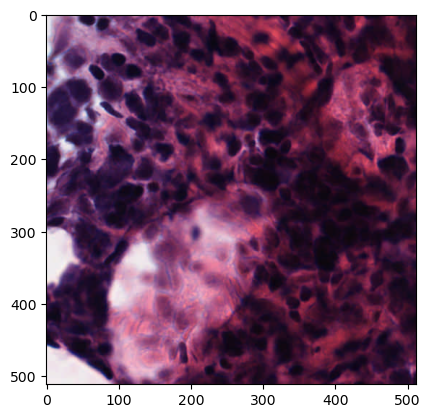

In [196]:
imgplot = plt.imshow(patch)

### Find outliers

In [197]:
def count_patches(patients):
    n = 0

    for patient in patients:
        n += len(list_patient_patches(patient))
    
    return n

In [198]:
patch_count = count_patches(patients=represented_patients)
print('Total number of patches:', patch_count)

Total number of patches: 98148


In [199]:
def list_outliers(threshold=(0, 1)):
    low, high = threshold

    outlier_paths = []

    for i, patient in enumerate(represented_patients):
        print(f'\r', f'Check all patients: {i}/{len(represented_patients)}',
              end='')
        patch_files = list_patient_patches(patient)

        for patch_file in patch_files:
            patch = load_patch(patch_file)
            means = compute_intensity_mean(patch, print_result=False)
            if not low < means[0] < high:
                outlier_paths.append(
                    os.path.join(DATA_LOCATION, 'tissue_patches', patient, patch_file))

    return outlier_paths

In [207]:
%%time

# Set thresholds by running some patients and looking at results
low = 0.35
high = 0.9

outlier_paths = []

for i, patient in enumerate(represented_patients):
    print(f'\rCheck all patients: {i}/{len(represented_patients)}', end='')
    patch_files = list_patient_patches(patient)

    for patch_file in patch_files:
        patch = load_patch(patch_file)
        if patch is None:
            continue  # skip corrupted or unreadable images
        means = compute_intensity_mean(patch, print_result=False)
        if not low < means[0] < high:
            outlier_paths.append(
                os.path.join(DATA_LOCATION, 'tissue_patches', patient, patch_file))

Check all patients: 189/913
Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_02624.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_058f7.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_0b154.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_0eea2.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_11924.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Processed_Data/WSI/tissue_patches/TCGA-AC-A4ZE/TCGA-AC-A4ZE-01Z-00-DX1_12fcd.png | Reason: Decompressed Data Too Large

Skipped corrupted image: /mnt/data/Process

In [208]:
percent_patches = round(len(outlier_paths) * 100 / patch_count, 1)
patients = set([x.split('/')[-2] for x in outlier_paths])
percent_patients = round(len(patients) * 100 / len(represented_patients), 1)

print(f'{len(outlier_paths)} outlier patches out of {patch_count} ({percent_patches}%)')
print(f'from {len(patients)} patients out of {len(represented_patients)} ({percent_patients}%)')

2258 outlier patches out of 98148 (2.3%)
from 483 patients out of 913 (52.9%)


### Visualize outlier examples

Channel     Mean
  R       0.320751
  G       0.136371
  B       0.252611


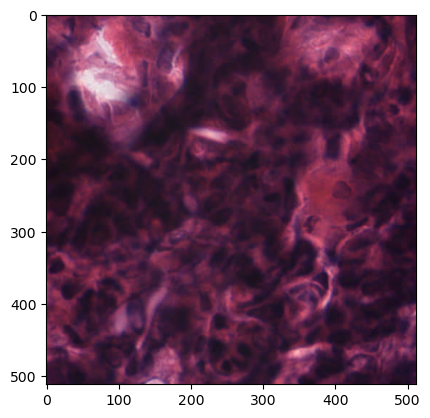

In [210]:
import random

i = random.randint(0, len(outlier_paths) - 1)
outlier_patch = load_patch(outlier_paths[i])
means = compute_intensity_mean(outlier_patch, print_result=True)
imgplot = plt.imshow(outlier_patch)

### Delete outlier patch files

In [211]:
all_patches = []
for pid in represented_patients:
    all_patches += list_patient_patches(patient_id=pid)

In [212]:
len(all_patches)

98148

In [213]:
def how_many_patches_per_patient(patches):
    patches_named_as_patients = ['-'.join(os.path.basename(patch).split('-')[:3])
                                 for patch in patches]
    
    c = Counter(patches_named_as_patients)

    print(f'# patches: {len(patches_named_as_patients)}')
    print(f'# Represented patients: {len(c)}')
    unique_counts = set(c.values())
    print(f'Unique #s patches per patient: {unique_counts}')

In [214]:
how_many_patches_per_patient(all_patches)

# patches: 98148
# Represented patients: 913
Unique #s patches per patient: {100, 200, 300, 400, 50, 149, 150, 249, 250, 350}


In [215]:
outlier_paths[:5]

['/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALJ/TCGA-3C-AALJ-01Z-00-DX1_d13ae.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-5L-AAT1/TCGA-5L-AAT1-01Z-00-DX1_0255f.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-5L-AAT1/TCGA-5L-AAT1-01Z-00-DX1_06db0.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-5L-AAT1/TCGA-5L-AAT1-01Z-00-DX1_13ef2.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-5L-AAT1/TCGA-5L-AAT1-01Z-00-DX1_18d8f.png']

In [216]:
len(outlier_paths)

2258

In [217]:
for f in outlier_paths:
    os.remove(f)

In [218]:
count_patches(patients=represented_patients)

95890

In [219]:
len(all_patches) - len(outlier_paths)

95890

### Generate patient files

Update patient files to account for deleted patches.

In [220]:
all_patches = []
for pid in represented_patients:
    all_patches += list_patient_patches(patient_id=pid)

In [221]:
all_patches_ids = list(set(['-'.join(os.path.basename(patch).split('-')[:3])
                            for patch in all_patches]))

for pid in represented_patients:
    if not pid in all_patches_ids:
        print(pid, 'no longer among represented patients')

In [222]:
len(all_patches)

95890

In [225]:
# Remove previous patient files
for f in os.listdir(DATA_LOCATION):
    if f != 'tissue_patches' and os.path.isfile(os.path.join(DATA_LOCATION, f)):
        os.remove(os.path.join(DATA_LOCATION, f))

In [226]:
os.listdir(DATA_LOCATION)

['test', 'tissue_patches', 'train', 'val']

In [227]:
patient_patch_map = {}

previous_id = None

for patch_path in all_patches:
    pid = '-'.join(os.path.basename(patch_path).split('-')[:3])
    
    if not pid in patient_patch_map.keys():
        patient_patch_map[pid] = [patch_path]
    else:
        patient_patch_map[pid].append(patch_path)

In [228]:
len(patient_patch_map)

913

In [232]:
patient_patch_map['TCGA-3C-AALI']

['/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_00146.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_020aa.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_062d5.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_08f92.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_0fa96.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_13bb6.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_184f5.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_1cebb.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_1f811.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA-3C-AALI/TCGA-3C-AALI-01A-01-TSA_206fc.png',
 '/mnt/data/Processed_Data/WSI/tissue_patches/TCGA

In [233]:
%%time

print('Write patient files:')

base_dir = '/mnt/data/Processed_Data/WSI/'
n = len(patient_patch_map)

for i, (patient, files) in enumerate(patient_patch_map.items()):
    print('\r' + f'{str((i + 1))}/{n}', end='')
    
    target_file = os.path.join(DATA_LOCATION, str(patient) + '.txt')

    with open(target_file, 'w') as f:
        f.write('\n'.join(patient_files))
print()

Write patient files:
913/913
CPU times: user 74.3 ms, sys: 58.6 ms, total: 133 ms
Wall time: 2.12 s


In [234]:
len([x for x in os.listdir(DATA_LOCATION) if x != 'tissue_patches'])

916

# Compute patch mean and std

Since the mean and standard deviation values of the WSI patches may differ from the ImageNet values provided by PyTorch, compute here sensible overall values from the dataset.

The dataloader samples random examples from each patient's available patches, so run through full dataloader a couple of times to check variability.

In [23]:
import sys

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

import utils

In [24]:
os.path.join(DATA_LOCATION, os.pardir)

'/mnt/data/Processed_Data/WSI/..'

In [25]:
dataloaders = utils.get_dataloaders(data_location=os.path.join(DATA_LOCATION, os.pardir),
                                    labels_file='labels.tsv',
                                    modalities=['wsi'],
                                    wsi_patch_size=560,
                                    n_wsi_patches=1,
                                    batch_size=32,
#                                     exclude_patients=exclude_cancers
                                   )

Excluding 149 patient(s) missing all data.
Excluding 16 patient(s) missing all data.
Excluding 16 patient(s) missing all data.
Data modalities:
   wsi

Dataset sizes (# patients):
   train: 727
   val: 94
   test: 92

Batch size: 32


In [26]:
for x in dataloaders['train']:
    print(x[0]['wsi'].shape)
    break

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 2276) exited unexpectedly

In [ ]:
x[0]['wsi'][:, :, 0, :, :].mean()

In [ ]:
x[0]['wsi'][:, :, 1, :, :].mean()

In [ ]:
x[0]['wsi'][:, :, 2, :, :].mean()

In [ ]:
x[0]['wsi'].shape[0]

In [ ]:
import torch
from tqdm.notebook import tqdm

def compute_wsi_patch_stats(data_loader=dataloaders['train']):
    n_channels = 3
    n = len(data_loader.dataset)

    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)

    print('Computing mean and std..')
    for minibatch in tqdm(data_loader):
        for j in range(minibatch[0]['wsi'].shape[0]):  # each individual patch
            for i in range(n_channels):
                mean_value = minibatch[0]['wsi'][:, :, i, :, :].mean()
                if mean_value > 0.1:  # avoid all-zero patches (missing data)
                    mean[i] += mean_value
                    std[i] += minibatch[0]['wsi'][:, :, i, :, :].std()
    mean.div_(n)
    std.div_(n)
    print(mean, std)
    
    return mean, std

In [ ]:
multiple_run_means = []
multiple_run_stds = []

In [ ]:
%%time

n_runs = 5

for _ in tqdm(range(n_runs)):
    mean, std = compute_wsi_patch_stats(data_loader=dataloaders['train'])
    
    multiple_run_means.append(mean)
    multiple_run_stds.append(std)
print()

In [ ]:
print('          -- Means --' + ' ' * 24 + '-- STDs --')
for i in range(len(multiple_run_means)):
    print(multiple_run_means[i], ' ', multiple_run_stds[i])

# Watermark <a class='tocSkip'></a>

In [ ]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

[Top of the page](#Top)